In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from copulas.multivariate import GaussianMultivariate

def alpha(f1,f2):
    y = 1.64*(f1-f2)-2.82
    return y


def mJy_to_mag(F, F0):
    m = -2.5*np.log10(F*0.001/F0)
    return m


def e_mJy_to_mag(e_F, F):
    m = (2.5/np.log(10))*(e_F/F)
    return m

# c2d CLOUDS/CORES

In [3]:
c2d = pd.read_csv("../Data/c2d_CLOUDS_HREL.csv")
# c2d = pd.read_csv("../Data/c2d_CORES_HREL.csv",index_col=1)

c2d.columns

Index(['region', 'c2d_id', 'ra', 'dec', 'alpha', 'object_type', 'j_flux_c',
       'j_d_flux_c', 'h_flux_c', 'h_d_flux_c', 'ks_flux_c', 'ks_d_flux_c',
       'ir1_flux_c', 'ir1_d_flux_c', 'ir2_flux_c', 'ir2_d_flux_c',
       'ir3_flux_c', 'ir3_d_flux_c', 'ir4_flux_c', 'ir4_d_flux_c',
       'mp1_flux_c', 'mp1_d_flux_c', 'mp2_flux_c', 'mp2_d_flux_c'],
      dtype='object')

### Determine Targets for dataframe

In [10]:
c2d_YSO_1 = pd.merge_ordered(c2d[c2d["object_type"]=='YSOc_star+dust(MP1)'],c2d[c2d["object_type"]=='YSOc_star+dust(IR4)'])
c2d_YSO_2 = pd.merge_ordered(c2d[c2d["object_type"]=='YSOc_star+dust(IR2)'],c2d[c2d["object_type"]=='YSOc_star+dust(IR3)'])
c2d_YSO_3 = pd.merge_ordered(c2d[c2d["object_type"]=='YSOc_star+dust(IR1)'],c2d[c2d["object_type"]=='YSOc_red'])
c2d_YSO_4 = pd.merge_ordered(c2d[c2d["object_type"]=='YSOc_PAH-em'],c2d[c2d["object_type"]=='YSOc'])
c2d_YSO_12 = pd.merge_ordered(c2d_YSO_1,c2d_YSO_2)
c2d_YSO_34 = pd.merge_ordered(c2d_YSO_3,c2d_YSO_4)
c2d_YSO = pd.merge_ordered(c2d_YSO_12,c2d_YSO_34)

c2d_YSO["Target"] = 0


c2d_EG_1 = pd.merge_ordered(c2d[c2d["object_type"]=='Galc_star+dust(MP1)'],c2d[c2d["object_type"]=='Galc_star+dust(IR4)'])
c2d_EG_2 = pd.merge_ordered(c2d[c2d["object_type"]=='Galc_star+dust(IR2)'],c2d[c2d["object_type"]=='Galc_star+dust(IR3)'])
c2d_EG_3 = pd.merge_ordered(c2d[c2d["object_type"]=='Galc_star+dust(IR1)'],c2d[c2d["object_type"]=='Galc_red'])
c2d_EG_4 = pd.merge_ordered(c2d[c2d["object_type"]=='Galc_PAH-em'],c2d[c2d["object_type"]=='Galc'])
c2d_EG_12 = pd.merge_ordered(c2d_EG_1,c2d_EG_2)
c2d_EG_34 = pd.merge_ordered(c2d_EG_3,c2d_EG_4)
c2d_EG = pd.merge_ordered(c2d_EG_12,c2d_EG_34)
c2d_EG["Target"] = 1


c2d_ST_1 = pd.merge_ordered(c2d[c2d["object_type"]=='star+dust(MP1)'],c2d[c2d["object_type"]=='star+dust(IR4)'])
c2d_ST_2 = pd.merge_ordered(c2d[c2d["object_type"]=='star+dust(IR2)'],c2d[c2d["object_type"]=='star+dust(IR3)'])
c2d_ST_3 = pd.merge_ordered(c2d[c2d["object_type"]=='Galc_star+dust(IR1)'],c2d[c2d["object_type"]=='star'])
c2d_ST_12 = pd.merge_ordered(c2d_ST_1,c2d_ST_2)
c2d_ST = pd.merge_ordered(c2d_ST_3,c2d_ST_12)
c2d_ST["Target"] = 2

c2d_1 = pd.merge_ordered(c2d_YSO,c2d_EG)
c2d_NEW = pd.merge_ordered(c2d_1,c2d_ST)

print(f"YSO shape: {c2d_YSO.shape}")
print(f"EG shape: {c2d_EG.shape}")
print(f"Star shape: {c2d_ST.shape}")

YSO shape: (1082, 25)
EG shape: (2888, 25)
Star shape: (282785, 25)


### Clean data

In [17]:
c2d_IRAC = c2d_NEW[["object_type","region","ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c",'mp1_flux_c', 'mp1_d_flux_c', "Target"]]
c2d_IRAC.dropna(inplace=True)

# Load in magnitude data
# Access data by band instead of object
band_names = ["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c",'mp1_flux_c', 'mp1_d_flux_c']
c2d_IRAC_fluxes = c2d_IRAC[band_names].values.astype(float).transpose() 
# Convert magnitudes to flux
for i, F_0 in enumerate([277.500, 277.500, 179.500, 179.500, 116.600, 116.600, 63.100, 63.100]):
    if i%2==0:
        c2d_IRAC[band_names[i]] = mJy_to_mag(c2d_IRAC_fluxes[i],F_0) # Convert fluxes in a column to mags
    else:
        c2d_IRAC[band_names[i]] = e_mJy_to_mag(c2d_IRAC_fluxes[i],c2d_IRAC_fluxes[i-1]) # Convert errors in a column to mag

# Add in alpha measurements
c2d_IRAC["alpha"] = alpha(c2d_IRAC["ir2_flux_c"],c2d_IRAC["mp1_flux_c"])

c2d_IRAC.dropna(inplace=True)

shape_YSO = c2d_IRAC[c2d_IRAC["Target"]==0].shape
shape_EG = c2d_IRAC[c2d_IRAC["Target"]==1].shape
shape_ST = c2d_IRAC[c2d_IRAC["Target"]==2].shape
print(f"YSO shape: {shape_YSO}")
print(f"EG shape: {shape_EG}")
print(f"Star shape: {shape_ST}")

YSO shape: (1082, 14)
EG shape: (2888, 14)
Star shape: (242824, 14)


### Use copulas to fill missing data -- Only stars have missing data in c2d CLOUDS so will not utilize.

In [24]:
#Create synthetic data
c2d_IRAC_NEW = c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c",'mp1_flux_c', 'mp1_d_flux_c',"alpha", "Target"]]

# Load a dataset with the real not-independent data
real_data_YS = c2d_IRAC_NEW[c2d_IRAC_NEW["Target"]==0]
real_data_EG = c2d_IRAC_NEW[c2d_IRAC_NEW["Target"]==1]

# Fit a gaussian copula to the data
copulaYS = GaussianMultivariate()
copulaYS.fit(real_data_YS)

# Sample synthetic data
N_YS = 5000 - real_data_YS.shape[0]
synthetic_data_YS = copulaYS.sample(N_YS)

# Fit a gaussian copula to the data
copulaEG = GaussianMultivariate()
copulaEG.fit(real_data_EG)

# Sample synthetic data
N_EG = 5000 - real_data_EG.shape[0]
synthetic_data_EG = copulaEG.sample(N_EG)

In [21]:
c2d_missing = c2d_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c",'mp1_flux_c', 'mp1_d_flux_c', "Target"]]
c2d_missing = c2d_missing[np.isnan(c2d_missing).any(1)]
print(c2d_missing.shape)
c2d_missing_YSO = c2d_missing[c2d_missing["Target"]==0]
c2d_missing_EG = c2d_missing[c2d_missing["Target"]==1]
c2d_missing_ST = c2d_missing[c2d_missing["Target"]==2]

print(c2d_missing_YSO.shape)
print(c2d_missing_EG.shape)
print(c2d_missing_ST.shape)

(29156, 11)
(0, 11)
(0, 11)
(29156, 11)


### Add synthetic data from copulas

In [26]:
c2d_IRAC_SYNTH = pd.merge_ordered(synthetic_data_YS,synthetic_data_EG)
c2d_IRAC_SYNTH.columns = ["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c",'mp1_flux_c', 'mp1_d_flux_c', "alpha","Target"]
c2d_IRAC_NEW_w_SYNTH = pd.merge_ordered(c2d_IRAC_NEW,c2d_IRAC_SYNTH)


shape_YSO = c2d_IRAC_NEW_w_SYNTH[c2d_IRAC_NEW_w_SYNTH["Target"]==0].shape
shape_EG = c2d_IRAC_NEW_w_SYNTH[c2d_IRAC_NEW_w_SYNTH["Target"]==1].shape
shape_ST = c2d_IRAC_NEW_w_SYNTH[c2d_IRAC_NEW_w_SYNTH["Target"]==2].shape
print(f"YSO shape: {shape_YSO}")
print(f"EG shape: {shape_EG}")
print(f"Star shape: {shape_ST}")
# c2d_IRAC_NEW_w_SYNTH.shape

YSO shape: (5000, 12)
EG shape: (5000, 12)
Star shape: (242824, 12)


### Save

In [27]:
np.save("../Data/c2d_Inputs_CLOUDS_SYNTH.npy",c2d_IRAC_NEW_w_SYNTH[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c",'mp1_flux_c', 'mp1_d_flux_c', "alpha"]].values.astype(float))
np.save("../Data/c2d_Targets_CLOUDS_SYNTH.npy",c2d_IRAC_NEW_w_SYNTH[["Target"]].values.astype(int))

# np.save("../Data_and_Results/c2d_Inputs_CORES_Valid.npy",c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","alpha"]].values.astype(float))
# np.save("../Data_and_Results/c2d_Targets_CORES_Valid.npy",c2d_IRAC_NEW[["Target"]].values.astype(int))

### View data histograms

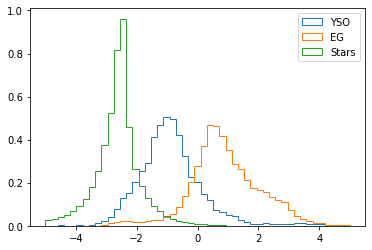

In [33]:
import matplotlib.pyplot as plt
bins= np.linspace(-5,5,20)

c2d_tar = c2d_IRAC_NEW_w_SYNTH[["Target"]].values.astype(int)
c2d_inp = c2d_IRAC_NEW_w_SYNTH[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","alpha"]].values.astype(float)
EG = np.where(c2d_tar==1)[0]
alphasEG = c2d_inp[EG].transpose()[8]

YSO = np.where(c2d_tar==0)[0]
alphasYS = c2d_inp[YSO].transpose()[8]

ST = np.where(c2d_tar==2)[0]
alphasST = c2d_inp[ST].transpose()[8]

bins= np.linspace(-5,5,50)
plt.hist(alphasYS,bins,histtype='step',label='YSO',density=True)
plt.hist(alphasEG,bins,histtype='step',label='EG',density=True)
plt.hist(alphasST,bins,histtype='step',label='Stars',density=True)
plt.legend()
plt.show()

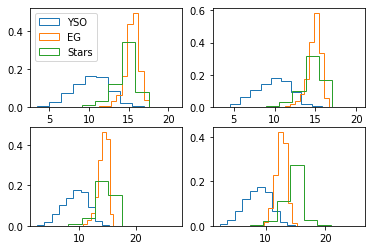

In [34]:
fig, axs = plt.subplots(2,2)
axs[0][0].hist(c2d_inp[YSO].transpose()[0],histtype='step',label='YSO',density=True)
axs[0][0].hist(c2d_inp[EG].transpose()[0],histtype='step',label='EG',density=True)
axs[0][0].hist(c2d_inp[ST].transpose()[0],histtype='step',label='Stars',density=True)
axs[0][0].legend()

axs[0][1].hist(c2d_inp[YSO].transpose()[2],histtype='step',label='YSO',density=True)
axs[0][1].hist(c2d_inp[EG].transpose()[2],histtype='step',label='EG',density=True)
axs[0][1].hist(c2d_inp[ST].transpose()[2],histtype='step',label='Stars',density=True)

axs[1][0].hist(c2d_inp[YSO].transpose()[4],histtype='step',label='YSO',density=True)
axs[1][0].hist(c2d_inp[EG].transpose()[4],histtype='step',label='EG',density=True)
axs[1][0].hist(c2d_inp[ST].transpose()[4],histtype='step',label='Stars',density=True)

axs[1][1].hist(c2d_inp[YSO].transpose()[6],histtype='step',label='YSO',density=True)
axs[1][1].hist(c2d_inp[EG].transpose()[6],histtype='step',label='EG',density=True)
axs[1][1].hist(c2d_inp[ST].transpose()[6],histtype='step',label='Stars',density=True)

plt.show()

# Rapson Data

In [73]:
df_Rap = pd.read_csv("../Data_and_Results/Rapson_YSO_EG_ST.tsv",sep=';',comment='#')

df_Rap = df_Rap.replace(r'^\s+$', np.nan, regex=True)
for name in ['3.6mag', 'e_3.6mag', '4.5mag', 'e_4.5mag','5.8mag', 'e_5.8mag', '8mag', 'e_8mag',"24mag","e_24mag"]:
    df_Rap[name] = df_Rap[name].astype(float)

    
df_Rap.info()
# pd.unique(df_Rap["4.5mag"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10454 entries, 0 to 10453
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        10454 non-null  int64  
 1   RAJ2000   10454 non-null  object 
 2   DEJ2000   10454 non-null  object 
 3   3.6mag    10445 non-null  float64
 4   e_3.6mag  10445 non-null  float64
 5   4.5mag    10450 non-null  float64
 6   e_4.5mag  10450 non-null  float64
 7   5.8mag    10249 non-null  float64
 8   e_5.8mag  10249 non-null  float64
 9   8mag      8484 non-null   float64
 10  e_8mag    8484 non-null   float64
 11  24mag     809 non-null    float64
 12  e_24mag   809 non-null    float64
 13  Class     10454 non-null  object 
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


,ID,RAJ2000,DEJ2000,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8mag,e_8mag,24mag,e_24mag,Class
0,14,06 43 14.76,+08 44 58.38,12.78,0.007,13.07,0.009,NaN,NaN,13.21,0.132,NaN,NaN,III/F
1,17,06 43 09.64,+08 45 00.18,14.07,0.022,14.02,0.022,NaN,NaN,NaN,NaN,NaN,NaN,III/F
2,21,06 43 13.37,+08 45 02.15,12.47,0.005,12.40,0.006,NaN,NaN,12.45,0.055,NaN,NaN,III/F
3,26,06 42 41.52,+08 45 06.44,13.78,0.011,13.65,0.015,13.68,0.105,NaN,NaN,NaN,NaN,III/F
4,34,06 43 10.32,+08 45 11.33,10.32,0.003,10.17,0.003,10.07,0.005,10.03,0.008,NaN,NaN,III/F


In [76]:
Rap_YSO_1 = pd.merge_ordered(df_Rap[df_Rap["Class"]=='0/I'],df_Rap[df_Rap["Class"]=='II'])
Rap_YSO = pd.merge_ordered(Rap_YSO_1,df_Rap[df_Rap["Class"]=='TD'])
Rap_YSO["Target"] = 0

Rap_EG_1 = pd.merge_ordered(df_Rap[df_Rap["Class"]=='AGN'],df_Rap[df_Rap["Class"]=='PAH'])
Rap_EG = pd.merge_ordered(Rap_EG_1,df_Rap[df_Rap["Class"]=='SHOCK'])
Rap_EG["Target"] = 1

Rap_ST = df_Rap[df_Rap["Class"]=="III/F"]
Rap_ST["Target"] = 2

Rap_NEW_1 = pd.merge_ordered(Rap_YSO,Rap_EG)
Rap_NEW = pd.merge_ordered(Rap_NEW_1, Rap_ST)

print(f"YSO shape: {Rap_YSO.shape}")
print(f"EG shape: {Rap_EG.shape}")
print(f"Stars shape: {Rap_ST.shape}")



# Calculate alphas and add to be consisitent with available bands ([4.5]-[8])
# df_Rap_clean["alpha"] = alpha(df_Rap_clean["4.5mag"].values.astype(float),df_Rap_clean["8mag"].values.astype(float))


YSO shape: (584, 15)
EG shape: (373, 15)
Stars shape: (9497, 15)


In [79]:
nan_ind = Rap_NEW[['3.6mag', 'e_3.6mag', '4.5mag', 'e_4.5mag','5.8mag', 'e_5.8mag', '8mag', 'e_8mag',"Target"]].index[np.isnan(Rap_NEW[['3.6mag', 'e_3.6mag', '4.5mag', 'e_4.5mag','5.8mag', 'e_5.8mag', '8mag', 'e_8mag','Target']]).any(1)]
df_Rap_clean = Rap_NEW.drop(nan_ind)
df_Rap_clean.head()

,ID,RAJ2000,DEJ2000,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8mag,e_8mag,24mag,e_24mag,Class,Target
4,34,06 43 10.32,+08 45 11.33,10.32,0.003,10.17,0.003,10.07,0.005,10.03,0.008,NaN,NaN,III/F,2
7,45,06 42 42.63,+08 45 20.25,11.62,0.003,11.60,0.004,11.55,0.016,11.56,0.035,NaN,NaN,III/F,2
9,54,06 43 02.63,+08 45 23.95,13.38,0.007,13.28,0.011,13.27,0.050,13.78,0.155,NaN,NaN,III/F,2
11,65,06 43 01.89,+08 45 32.18,12.52,0.005,12.52,0.006,12.40,0.030,12.41,0.053,NaN,NaN,III/F,2
15,84,06 42 53.88,+08 45 38.50,13.71,0.009,13.66,0.013,13.60,0.069,13.67,0.148,NaN,NaN,III/F,2


In [80]:
#Create synthetic data
df_Rap_Synth_NEW = df_Rap_clean[['3.6mag', 'e_3.6mag', '4.5mag', 'e_4.5mag','5.8mag', 'e_5.8mag', '8mag', 'e_8mag',"Target"]]

# Load a dataset with 3 columns that are not independent
real_data_YS = df_Rap_Synth_NEW[df_Rap_Synth_NEW["Target"]==0].values.astype(float)
real_data_EG = df_Rap_Synth_NEW[df_Rap_Synth_NEW["Target"]==1].values.astype(float)

# Fit a gaussian copula to the data
copulaYS = GaussianMultivariate()
copulaYS.fit(real_data_YS)

# Sample synthetic data
N_YS = 1000 - real_data_YS.shape[0]
synthetic_data_YS = copulaYS.sample(N_YS)

# Fit a gaussian copula to the data
copulaEG = GaussianMultivariate()
copulaEG.fit(real_data_EG)

# Sample synthetic data
N_EG = 1000 - real_data_EG.shape[0]
synthetic_data_EG = copulaEG.sample(N_EG)

In [82]:
Rap_missing = Rap_NEW[['3.6mag', 'e_3.6mag', '4.5mag', 'e_4.5mag','5.8mag', 'e_5.8mag', '8mag', 'e_8mag',"Target"]]
Rap_missing = Rap_missing[np.isnan(Rap_missing).any(1)]
print(Rap_missing.shape)
Rap_missing_YSO = Rap_missing[Rap_missing["Target"]==0]
Rap_missing_EG = Rap_missing[Rap_missing["Target"]==1]
Rap_missing_ST = Rap_missing[Rap_missing["Target"]==2]

print(c2d_missing_YSO.shape)
print(c2d_missing_EG.shape)
print(c2d_missing_ST.shape)

(2010, 9)
(0, 9)
(0, 9)
(24471, 9)


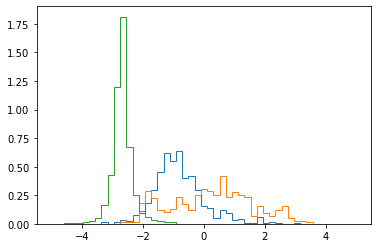

In [89]:
Rap_tar = Rap_NEW[["Target"]].values.astype(int)
Rap_inp = Rap_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8mag","e_8mag","alpha"]].values.astype(float)
EG = np.where(Rap_tar==1)[0]
alphasEG = Rap_inp[EG].transpose()[8]

YSO = np.where(Rap_tar==0)[0]
alphasYS = Rap_inp[YSO].transpose()[8]

ST = np.where(Rap_tar==2)[0]
alphasST = Rap_inp[ST].transpose()[8]

bins= np.linspace(-5,5,50)
plt.hist(alphasYS,bins,histtype='step',label='YSO',density=True)
plt.hist(alphasEG,bins,histtype='step',label='EG',density=True)
plt.hist(alphasST,bins,histtype='step',label='Stars',density=True)

plt.show()

In [39]:
np.save("../Data_and_Results/Rap_Inputs_Test.npy",Rap_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8mag","e_8mag","alpha"]].values.astype(float))
np.save("../Data_and_Results/Rap_Targets_Test.npy",Rap_NEW[["Target"]].values.astype(int))

# Data from CM21


If we follow the values CM21 used for each class, we should be using:
* Training
    * 1472 YSOs (331 CI and 1141 CII)
    * 857 EG (231 Gals, 529 AGN, 27 PAHs 70 Shocks)
    * 1257 Stars
* Validation
    * 613 YSOs (82 CI and 531 CII)
    * 405 EG (104 Gals, 278 AGNs, 6 PAHs, 17 Shocks)
    * 4359 Stars

We will use the above input and compare to using 1000 of each class. There are a total of:
* 3073 YSOs
* 2034 EG
* 21 796 Stars


# SPICY YSO Classification

In [5]:
df_SPICY = pd.read_csv("../Data_and_Results/SPICY_YSO_Subclasses.csv",comment='#')

df_SPICY.head()

,SPICY,RAdeg DEdeg,GLON GLAT,p1,p2,p3,class,Si,PAH,alpha,...,ag.1,ag.2,ag.3,2MASS,UKIDSS,VIRAC,GaiaDR2,MIPS,WISEA,ZTFDR3
0,1,125.664811 -37.551349,255.975183 -0.253369,0.710000,,,ClassII,0,0,-1.51695368300395E+00,...,2,2,2,08223956-3733048,,,5541983493883598976,,J082239.55-373304.5,NaN
1,2,125.795513 -37.585000,256.062070 -0.187675,0.690000,,,ClassII,0,0,-6.43206342197073E-01,...,2,2,2,08231092-3735060,,,5541980848188474496,,J082310.90-373505.9,NaN
2,3,125.860244 -37.577463,256.085297 -0.141319,0.870000,,,FS,0,0,-2.14090416881411E-03,...,2,2,2,08232646-3734388,,,5541969475116705664,,J082326.45-373438.8,NaN
3,4,125.946863 -37.770809,256.282985 -0.196119,0.530000,,,ClassI,0,0,3.37295842881326E-01,...,4,2,4,,,,,,J082347.25-374615.0,NaN
4,5,126.003155 -37.126075,255.780917 0.210831,0.540000,,,FS,0,0,-2.78597489454348E-01,...,2,2,2,08240071-3707341,,,5542020537982099840,,J082400.75-370733.7,NaN


In [6]:
df_SPICY_IRAC = df_SPICY[[" SPICY","3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","class    "]]
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["8.0mag"]!='      ']
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["5.8mag"]!='      ']

df_SPICY_IRAC.head()

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS


In [11]:
df_SPICY_CI = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassI   "]
df_SPICY_CI["Target"] = 0

df_SPICY_CFS = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="FS       "]
df_SPICY_CFS["Target"] = 1

df_SPICY_CII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassII  "]
df_SPICY_CII["Target"] = 2

df_SPICY_CIII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassIII "]
df_SPICY_CIII["Target"] = 3

df_YSO_NEW_1 = pd.merge_ordered(df_SPICY_CI,df_SPICY_CII)
df_YSO_NEW_2 = pd.merge_ordered(df_SPICY_CFS,df_SPICY_CIII)
df_YSO_NEW = pd.merge_ordered(df_YSO_NEW_1,df_YSO_NEW_2)

df_YSO_NEW['alphas'] = alpha(df_YSO_NEW["4.5mag"].values.astype(float),df_YSO_NEW["8.0mag"].values.astype(float))

df_YSO_NEW.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CI["Target"] = 0
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CFS["Target"] = 1
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class,Target,alphas
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII,2,-1.52276
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII,2,-0.65028
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS,1,-0.16156
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI,0,0.32880
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS,1,-0.28620


In [12]:
Inputs = df_YSO_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","alphas"]].values.astype(float)
Targets = df_YSO_NEW[["Target"]].values.astype(float)


np.save("../Data_and_Results/Inputs_YSO_Train.npy",Inputs)
np.save("../Data_and_Results/Targets_YSO_Train.npy",Targets)

In [10]:
print(df_SPICY_CI.shape)
print(df_SPICY_CII.shape)
print(df_SPICY_CFS.shape)
print(df_SPICY_CIII.shape)

(15596, 11)
(59561, 11)
(23563, 11)
(5333, 11)
